# SVC_GPU

In [1]:
# Install required packages
!pip install -q cudf-cu12 cuml-cu12 cupy-cuda12x

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("/content/dysnet1.csv")

In [5]:
import cudf
import cuml
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
import numpy as np
import pandas as pd
import time
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ParameterGrid
import joblib

# Convert pandas DataFrame to cuDF
df_gpu = cudf.DataFrame(df)
X = df_gpu.drop('label', axis=1)
y = df_gpu['label']

# Convert data to float32 for better GPU performance
X = X.astype('float32')
y = y.astype('float32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data using GPU
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to numpy arrays for sklearn
X_train_scaled_cpu = X_train_scaled.values.get()
X_test_scaled_cpu = X_test_scaled.values.get()
y_train_cpu = y_train.values.get()
y_test_cpu = y_test.values.get()

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate': ['adaptive'],
    'max_iter': [1000],
    'alpha': [0.0001, 0.001],
    'batch_size': [256],
}

# Calculate total combinations
total_combinations = len(list(ParameterGrid(param_grid)))
print(f"Total parameter combinations: {total_combinations}")

# Initialize variables
best_score = 0
best_params = None
best_model = None

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Grid search with progress tracking
start_time = time.time()
for i, params in enumerate(ParameterGrid(param_grid), 1):
    iteration_start = time.time()
    current_time = time.strftime('%H:%M:%S')

    print(f"\nCombination {i}/{total_combinations} at {current_time}")
    print(f"Parameters: {params}")

    model = MLPClassifier(
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        verbose=False,
        **params
    )

    model.fit(X_train_scaled_cpu, y_train_cpu)
    train_score = model.score(X_train_scaled_cpu, y_train_cpu)
    test_score = model.score(X_test_scaled_cpu, y_test_cpu)

    iteration_time = time.time() - iteration_start

    print(f"Training Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"Iteration Time: {format_time(iteration_time)}")

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
total_time = time.time() - start_time
print("\n" + "="*50)
print("Grid Search Completed!")
print(f"Total Time: {format_time(total_time)}")
print(f"Best Parameters: {best_params}")
print(f"Best Training Score: {best_model.score(X_train_scaled_cpu, y_train_cpu):.4f}")
print(f"Best Test Score: {best_score:.4f}")

# Save the best model
joblib.dump(best_model, 'MLP_GPU.pkl')

# Fine-tuning phase
print("\nStarting fine-tuning phase...")

fine_tune_grid = {
    'hidden_layer_sizes': [
        (best_params['hidden_layer_sizes'][0] - 20,),
        best_params['hidden_layer_sizes'],
        (best_params['hidden_layer_sizes'][0] + 20,)
    ],
    'alpha': [
        best_params['alpha'] * 0.5,
        best_params['alpha'],
        best_params['alpha'] * 2
    ],
    'batch_size': [128, 256, 512],
    'activation': [best_params['activation']],
    'learning_rate': [best_params['learning_rate']],
    'max_iter': [best_params['max_iter']]
}

# Fine-tuning search
fine_tune_start = time.time()
for i, params in enumerate(ParameterGrid(fine_tune_grid), 1):
    iteration_start = time.time()
    print(f"\nFine-tuning combination {i}/{len(list(ParameterGrid(fine_tune_grid)))}")

    model = MLPClassifier(
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        verbose=False,
        **params
    )

    model.fit(X_train_scaled_cpu, y_train_cpu)
    test_score = model.score(X_test_scaled_cpu, y_test_cpu)

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
print("\n" + "="*50)
print("Fine-tuning Completed!")
print(f"Final Best Parameters: {best_params}")
print(f"Final Best Score: {best_score:.4f}")

# Save the final model
joblib.dump(best_model, 'MLP_GPU_final.pkl')

Total parameter combinations: 8

Combination 1/8 at 04:15:45
Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 256, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 1000}
Training Score: 0.9765
Test Score: 0.9644
Iteration Time: 00:00:55
New best score: 0.9644

Combination 2/8 at 04:16:41
Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 256, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'max_iter': 1000}
Training Score: 0.9862
Test Score: 0.9703
Iteration Time: 00:00:44
New best score: 0.9703

Combination 3/8 at 04:17:26
Parameters: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 256, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 1000}
Training Score: 0.9761
Test Score: 0.9639
Iteration Time: 00:00:54

Combination 4/8 at 04:18:20
Parameters: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 256, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'max_iter': 1000}
Training 

['MLP_GPU_final.pkl']

In [6]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test_scaled_cpu)
print(classification_report(y_test_cpu, y_pred))
print(confusion_matrix(y_test_cpu, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     16179
         1.0       0.97      0.97      0.97     15932

    accuracy                           0.97     32111
   macro avg       0.97      0.97      0.97     32111
weighted avg       0.97      0.97      0.97     32111

[[15708   471]
 [  457 15475]]


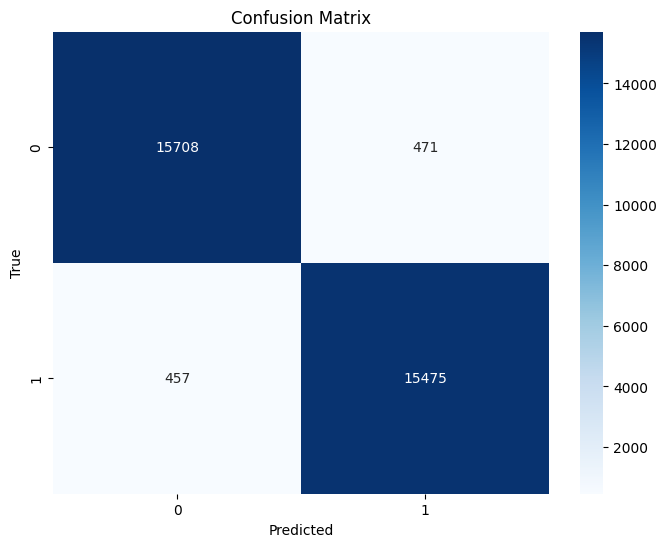

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert only y_test if it's still on GPU (cudf Series)
if hasattr(y_test, 'to_numpy'):
    y_test_cpu = y_test.to_numpy()
else:
    y_test_cpu = y_test

# y_pred is already a numpy array, so use it directly
y_pred_cpu = y_pred

# Create and plot confusion matrix
cm = confusion_matrix(y_test_cpu, y_pred_cpu)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# SVC

In [5]:
import cudf
import cuml
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
from cuml.svm import SVC
import numpy as np
import time
import joblib
from sklearn.model_selection import ParameterGrid

# Convert pandas DataFrame to cuDF
df_gpu = cudf.DataFrame(df)
X = df_gpu.drop('label', axis=1)
y = df_gpu['label']

# Convert data to float32 for better GPU performance
X = X.astype('float32')
y = y.astype('float32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data using GPU
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for SVC
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
}

# Calculate total combinations
total_combinations = len([p for p in ParameterGrid(param_grid)])
print(f"Total parameter combinations: {total_combinations}")

# Initialize variables
best_score = 0
best_params = None
best_model = None

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Grid search with progress tracking
start_time = time.time()
for i, params in enumerate(ParameterGrid(param_grid), 1):
    iteration_start = time.time()
    current_time = time.strftime('%H:%M:%S')

    print(f"\nCombination {i}/{total_combinations} at {current_time}")
    print(f"Parameters: {params}")

    model = SVC(
        probability=True,
        random_state=42,
        **params
    )

    model.fit(X_train_scaled, y_train)
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)

    iteration_time = time.time() - iteration_start

    print(f"Training Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"Iteration Time: {format_time(iteration_time)}")

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
total_time = time.time() - start_time
print("\n" + "="*50)
print("Grid Search Completed!")
print(f"Total Time: {format_time(total_time)}")
print(f"Best Parameters: {best_params}")
print(f"Best Training Score: {best_model.score(X_train_scaled, y_train):.4f}")
print(f"Best Test Score: {best_score:.4f}")

# Save the best model
joblib.dump(best_model, 'SVC_GPU.pkl')

# Fine-tuning phase
print("\nStarting fine-tuning phase...")

# Create fine-tuning grid based on best parameters
fine_tune_grid = {
    'C': [best_params['C'] * 0.5, best_params['C'], best_params['C'] * 2],
    'kernel': [best_params['kernel']],
    'gamma': [best_params['gamma']] if best_params['gamma'] in ['scale', 'auto']
             else [best_params['gamma'] * 0.5, best_params['gamma'], best_params['gamma'] * 2],
}

# Fine-tuning search
fine_tune_start = time.time()
for i, params in enumerate(ParameterGrid(fine_tune_grid), 1):
    iteration_start = time.time()
    print(f"\nFine-tuning combination {i}/{len(list(ParameterGrid(fine_tune_grid)))}")

    model = SVC(
        probability=True,
        random_state=42,
        **params
    )

    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
print("\n" + "="*50)
print("Fine-tuning Completed!")
print(f"Final Best Parameters: {best_params}")
print(f"Final Best Score: {best_score:.4f}")

# Save the final model
joblib.dump(best_model, 'SVC_GPU_final.pkl')

# For predictions later, use:
y_pred = best_model.predict(X_test_scaled)

Total parameter combinations: 24

Combination 1/24 at 05:06:29
Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
[W] [05:06:29.955531] Random state is currently ignored by probabilistic SVC
Training Score: 0.9475
Test Score: 0.9472
Iteration Time: 00:00:15
New best score: 0.9472

Combination 2/24 at 05:06:45
Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
[W] [05:06:45.758161] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
[W] [05:06:45.758202] Random state is currently ignored by probabilistic SVC
Training Score: 0.8889
Test Score: 0.8909
Iteration Time: 00:00:12

Combination 3/24 at 05:06:57
Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
[W] [05:06:57.867061] Random state is currently ignored by probabilistic SVC
Training Score: 0.9475
Test Score: 0.9472
Iteration Time: 00:00:11
New best score: 0.9472

Combination 4/24 at 05:07:09
Parameters: 

In [14]:
y_test_cpu = y_test.values.get()
y_pred_cpu = y_pred.values.get()

In [15]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test_cpu, y_pred_cpu))
print(confusion_matrix(y_test_cpu, y_pred_cpu))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     16179
         1.0       0.98      0.98      0.98     15932

    accuracy                           0.98     32111
   macro avg       0.98      0.98      0.98     32111
weighted avg       0.98      0.98      0.98     32111

[[15835   344]
 [  381 15551]]


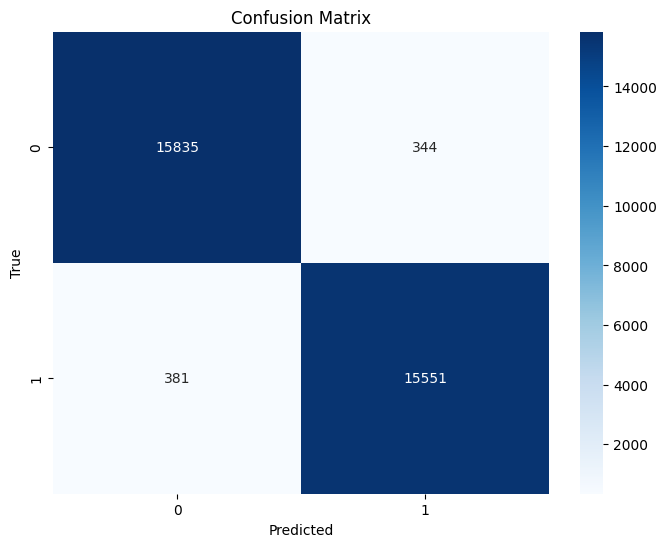

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert predictions and test labels to CPU for plotting
y_test_cpu = y_test.values.get()
y_pred_cpu = y_pred.values.get()

# Create and plot confusion matrix
cm = confusion_matrix(y_test_cpu, y_pred_cpu)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()